In [1]:
import os, sys
import numpy as np
import scipy.io as sio
from skimage import io
import skimage.transform
import matplotlib.pyplot as plt
import matplotlib.patches as patches

sys.path.append('..')
import face3d
import trimesh
from face3d import mesh
from face3d.morphable_model import MorphabelModel

import ipywidgets as widgets

In [2]:
image_path = 'Data/300W_LP/IBUG/IBUG_image_003_1_0.jpg'
mat_path = 'Data/300W_LP/IBUG/IBUG_image_003_1_0.mat'
save_folder = 'single_results/posmap_300WLP_4995'

In [3]:
# uv_coords = face3d.morphable_model.load.load_uv_coords('Data/BFM/Out/BFM_UV.mat')
# uv_coords = process_uv(uv_coords, uv_h, uv_w)
bfm = MorphabelModel('Data/BFM/Out/BFM.mat')

In [4]:
info = sio.loadmat(mat_path)
pose_para = info['Pose_Para'].T.astype(np.float32)
shape_para = info['Shape_Para'].astype(np.float32)
exp_para = info['Exp_Para'].astype(np.float32)
vertices = bfm.generate_vertices(shape_para, exp_para)

image = io.imread(image_path)/255.
[h, w, c] = image.shape

In [5]:
# 2. generate mesh
# generate shape
vertices = bfm.generate_vertices(shape_para, exp_para)
# transform mesh
s = pose_para[-1, 0]
angles = pose_para[:3, 0]
t = pose_para[3:6, 0]
transformed_vertices = bfm.transform_3ddfa(vertices, s, angles, t)
projected_vertices = transformed_vertices.copy() # using stantard camera & orth projection as in 3DDFA
image_vertices = projected_vertices.copy()
image_vertices[:,1] = h - image_vertices[:,1] - 1

# 3. crop image with key points
kpt = image_vertices[bfm.kpt_ind, :].astype(np.int32)
left = np.min(kpt[:, 0])
right = np.max(kpt[:, 0])
top = np.min(kpt[:, 1])
bottom = np.max(kpt[:, 1])
center = np.array([right - (right - left) / 2.0, 
        bottom - (bottom - top) / 2.0])
old_size = (right - left + bottom - top)/2
size = int(old_size*1.5)
# random pertube. you can change the numbers
marg = old_size*0.1
t_x = np.random.rand()*marg*2 - marg
t_y = np.random.rand()*marg*2 - marg
center[0] = center[0]+t_x; center[1] = center[1]+t_y
size = size*(np.random.rand()*0.2 + 0.9)


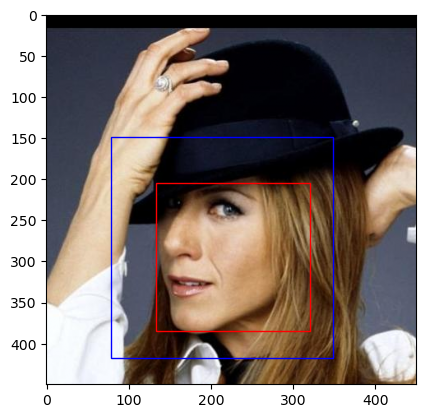

In [6]:
# Assuming you have the original image loaded as `image`
plt.imshow(image)

# # Plot keypoints
# plt.scatter(kpt[:, 0], kpt[:, 1], c='red', marker='o')

# # Draw the original bounding box
rect = patches.Rectangle((left, top), right-left, bottom-top, linewidth=1, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect)

# # Draw the perturbed bounding box
# # Calculate new left, right, top, bottom based on perturbed center and size
new_left = center[0] - size / 2
new_right = center[0] + size / 2
new_top = center[1] - size / 2
new_bottom = center[1] + size / 2

rect_perturbed = patches.Rectangle((new_left, new_top), new_right-new_left, new_bottom-new_top, linewidth=1, edgecolor='blue', facecolor='none')
plt.gca().add_patch(rect_perturbed)

plt.show()

In [7]:
faces = bfm.full_triangles

# Create a trimesh mesh object
mesh = trimesh.Trimesh(vertices=vertices, faces=faces)

if not mesh.is_volume:
    print("Warning: The mesh is not a valid volume. This might affect proximity queries.")

In [8]:
mesh.show()

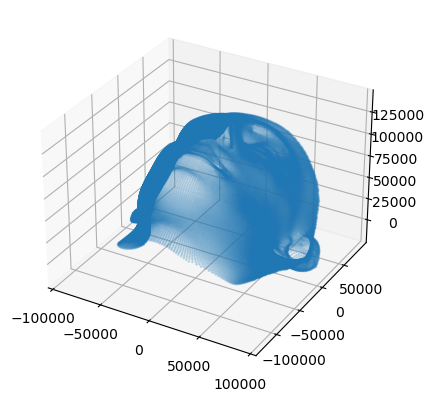

In [9]:
point_cloud = trimesh.points.PointCloud(vertices)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.plot_trisurf(vertices[:, 0], vertices[:, 1], faces, vertices[:, 2], color='pink', alpha=0.3)
ax.scatter(point_cloud.vertices[:, 0], point_cloud.vertices[:, 1], point_cloud.vertices[:, 2], s=1, alpha=0.2)
plt.show()

In [3]:
prediction_file = '../../predictions/AFW_134212_1_0_prediction.npy'
predicted_posmap = np.load(prediction_file)

FileNotFoundError: [Errno 2] No such file or directory: 'predictions/AFW_134212_1_0_prediction.npy'

In [10]:
# Find the geometric center of the model
face_center = np.mean(vertices, axis=0)

# z_offset = -15000

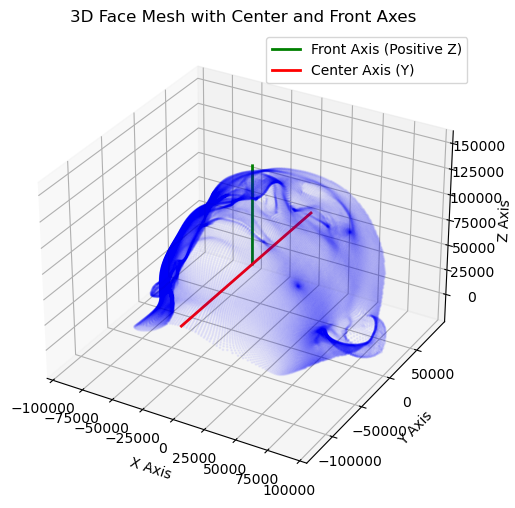

In [11]:
x, y, z = vertices[:,0], vertices[:,1], vertices[:,2]
center_x, center_y, center_z = face_center[0], face_center[1], face_center[2]

y_min_index = np.argmin(vertices[:, 1])
vertex_at_y_min = vertices[y_min_index]

# Extract the z-value of this vertex
z_offset = vertex_at_y_min[2] - center_z

center_z += z_offset

ax.scatter(vertex_at_y_min[0], vertex_at_y_min[1], vertex_at_y_min[2], color='red', s=10, alpha=1)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, color='blue', s=1, alpha=0.05)

# Plot the front-facing axis (positive z-axis)
z_front_min, z_front_max = center_z, 150000
ax.plot([center_x, center_x], [center_y, center_y], [z_front_min, z_front_max], color='green', linewidth=2, label='Front Axis (Positive Z)')

# Plot the center axis
ax.plot([center_x, center_x], [np.min(y), np.max(y)], [center_z, center_z], color='red', linewidth=2, label='Center Axis (Y)')

# Set labels and title
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('3D Face Mesh with Center and Front Axes')
ax.legend()

plt.show()

In [12]:
def crop_and_shift_mesh(vertices, faces, z_offset):
    """
    Efficiently crop a mesh at a specified Z offset and shift it to z=0.

    :param vertices: Nx3 numpy array of vertices.
    :param faces: Mx3 numpy array of faces (indices into vertices).
    :param z_offset: Z value at which to crop the mesh.
    :return: Cropped and shifted vertices and faces.
    """
    # Filter vertices below the z_offset
    valid_vertices_mask = vertices[:, 2] >= z_offset
    cropped_vertices = vertices[valid_vertices_mask]

    # Shift the mesh so the base lies at z=0
    min_z = np.min(cropped_vertices[:, 2])
    cropped_vertices[:, 2] -= min_z

    # Create a mapping from old vertex indices to new indices
    index_mapping = np.full(vertices.shape[0], -1, dtype=int)
    index_mapping[valid_vertices_mask] = np.arange(cropped_vertices.shape[0])

    # Update faces
    mapped_faces = index_mapping[faces]
    valid_faces_mask = np.all(mapped_faces >= 0, axis=1)
    cropped_faces = mapped_faces[valid_faces_mask]

    return cropped_vertices, cropped_faces

cropped_vertices, cropped_faces = crop_and_shift_mesh(vertices, faces, center_z)

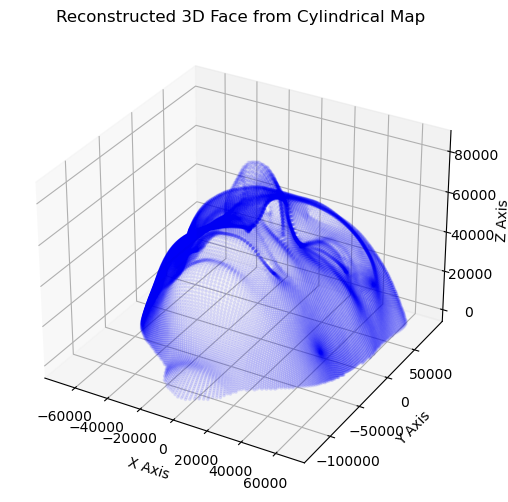

In [13]:
%matplotlib inline
# Plotting the reconstructed vertices
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Assuming reconstructed_vertices contains [x, y, z] coordinates
ax.scatter(cropped_vertices[:,0], cropped_vertices[:,1], cropped_vertices[:,2], color='blue', s=3, alpha=0.08)

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('Reconstructed 3D Face from Cylindrical Map')
# ax.view_init(elev=90, azim=270)
plt.show()

In [14]:
def get_vertex_position_on_radial_map(vertex, face_center, res_phi, res_y, min_y, max_y):
    r, phi, y = cartesian_to_cylindrical_vertical_axis(vertex, face_center)

    leftmost_phi = -np.pi/2
    rightmost_phi = np.pi/2
    if leftmost_phi <= phi <= rightmost_phi:
        phi_normalized = (phi - leftmost_phi) / (rightmost_phi - leftmost_phi)
        y_normalized = (y - min_y) / (max_y - min_y)

        i = int(phi_normalized * (res_phi - 1))
        j = res_y - 1 - int(y_normalized * (res_y - 1))

        return r, i, j
    else:
        return None

def map_position_to_vertex(i, j, r, face_center, res_phi, res_y, min_y, max_y):
    # Denormalize the map coordinates
    phi_normalized = i / (res_phi - 1)
    y_normalized = 1 - j / (res_y - 1)

    # Convert normalized coordinates back to original phi and y
    phi = phi_normalized * (np.pi) - np.pi / 2
    y = y_normalized * (max_y - min_y) + min_y

    # Convert from cylindrical back to Cartesian coordinates
    x = np.cos(phi) * r + face_center[0]
    z = np.sin(phi) * r
    return x, y, z

def cartesian_to_cylindrical_vertical_axis(vertex, face_center):
    x, z, y = vertex[0] - face_center[0], vertex[2], vertex[1]
    r = np.sqrt(x**2 + z**2)
    phi = np.arctan2(x, z)
    return r, phi, y

In [15]:
# initialize the radial map
res_phi, res_y = 512, 512  # Resolution of the cylindrical map, adjust as needed!
radial_map = np.zeros((res_y, res_phi))

In [16]:
# Precompute min and max y values for normalization
min_y, max_y = np.min(cropped_vertices[:,1]), np.max(cropped_vertices[:,1])

# Initialize the radial map
radial_map = np.zeros((res_y, res_phi))

# Populate the radial map
for vertex in cropped_vertices:
    result = get_vertex_position_on_radial_map(vertex, face_center, res_phi, res_y, min_y, max_y)
    
    if result is not None:
        r, i, j = result
        radial_map[j, i] = r

# Normalize the radial map for visualization
radial_map_normalized = (radial_map - np.min(radial_map)) / (np.max(radial_map) - np.min(radial_map))

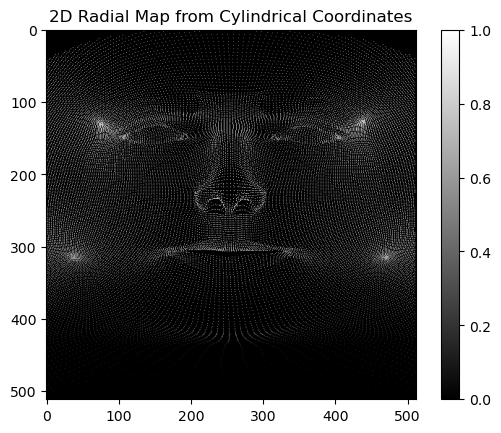

In [17]:
%matplotlib inline
plt.imshow(radial_map_normalized, cmap='gray')
plt.colorbar()
plt.title("2D Radial Map from Cylindrical Coordinates")
plt.show()

In [18]:
def find_bounding_box_and_vertices_of_triangle(triangle, face_center, res_phi, res_y, min_y, max_y):
    results = [get_vertex_position_on_radial_map(vertex, face_center, res_phi, res_y, min_y, max_y) for vertex in triangle]
    results = [result for result in results if result is not None]

    if len(results) != 3:
        return None, None, None

    # Unpack results
    depths, indices = zip(*[(result[0], (result[1], result[2])) for result in results])
    indices_i, indices_j = zip(*indices)

    # Calculate bounding box
    min_i, max_i = min(indices_i), max(indices_i)
    min_j, max_j = min(indices_j), max(indices_j)
    bounding_box = (min_i, max_i, min_j, max_j)

    return bounding_box, depths, indices

def update_interpolated_map_normalized(interpolated_map_normalized, bbox, interpolated_map):
    min_i, max_i, min_j, max_j = bbox
    slice_i = slice(min_i, max_i + 1)
    slice_j = slice(min_j, max_j + 1)

    # Update the normalized map
    interpolated_map_normalized[slice_j, slice_i] = np.maximum(
        interpolated_map_normalized[slice_j, slice_i],
        interpolated_map[:max_j - min_j + 1, :max_i - min_i + 1]
    )

In [19]:
def interpolate_depth_within_bounding_box(map_vertices, triangle_depths, bounding_box, res_phi, res_y):
    min_i, max_i, min_j, max_j = bounding_box
    bbox_height = max_j - min_j + 1
    bbox_width = max_i - min_i + 1
    interpolated_depths = np.zeros((bbox_height, bbox_width))

    # Preparing for vectorized barycentric coordinates calculation
    tri_vertices = np.array([[v[0], v[1]] for v in map_vertices])
    A, B, C = tri_vertices
    v0 = B - A
    v1 = C - A
    d00 = np.dot(v0, v0)
    d01 = np.dot(v0, v1)
    d11 = np.dot(v1, v1)
    denom = d00 * d11 - d01 * d01

    # Create a grid of points within the bounding box
    i_grid, j_grid = np.meshgrid(np.arange(min_i, max_i + 1), np.arange(min_j, max_j + 1))
    points = np.vstack([i_grid.ravel(), j_grid.ravel()]).T

    # Calculate barycentric coordinates for all points in the grid
    v2 = points - A
    v0_2d = v0[np.newaxis, :]
    v1_2d = v1[np.newaxis, :]
    d20 = np.einsum('ij,ji->i', v2, v0_2d.T)
    d21 = np.einsum('ij,ji->i', v2, v1_2d.T)

    if np.abs(denom) < 1e-10:
        return np.zeros_like(i_grid, dtype=float)
    
    v = (d11 * d20 - d01 * d21) / denom
    w = (d00 * d21 - d01 * d20) / denom
    u = 1.0 - v - w

    # Identify points inside the triangle
    inside_triangle = (u >= 0) & (v >= 0) & (w >= 0)
    valid_points = points[inside_triangle]
    valid_u = u[inside_triangle]
    valid_v = v[inside_triangle]
    valid_w = w[inside_triangle]

    inside_triangle_reshaped = inside_triangle.reshape(bbox_height, bbox_width)

    # Interpolate depth values for points inside the triangle
    interpolated_depths = np.zeros_like(i_grid, dtype=float)
    interpolated_depths[inside_triangle_reshaped] = triangle_depths[0] * valid_u + triangle_depths[1] * valid_v + triangle_depths[2] * valid_w

    return interpolated_depths

In [32]:
min_y, max_y = np.min(cropped_vertices[:,1]), np.max(cropped_vertices[:,1])
interpolated_map_normalized = np.zeros((res_y, res_phi))
for triangle_indices in cropped_faces:
    triangle_vertices = [cropped_vertices[index] for index in triangle_indices]
    bbox, triangle_depths, triangle_map_vertices = find_bounding_box_and_vertices_of_triangle(triangle_vertices, face_center, res_phi, res_y, min_y, max_y)
    if bbox is None:
        continue

    interpolated_map = interpolate_depth_within_bounding_box(triangle_map_vertices, triangle_depths, bbox, res_phi, res_y)
    update_interpolated_map_normalized(interpolated_map_normalized, bbox, interpolated_map)

C:\Users\chenb\AppData\Local\Temp\ipykernel_5172\175590238.py:15: RuntimeWarning: overflow encountered in scalar multiply
  denom = d00 * d11 - d01 * d01


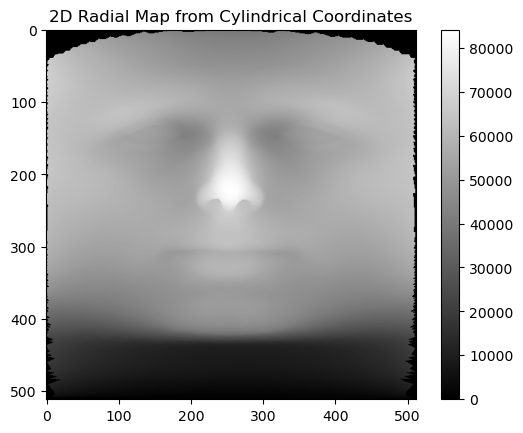

In [33]:
%matplotlib inline
plt.imshow(interpolated_map_normalized, cmap='gray')
plt.colorbar()
plt.title("2D Radial Map from Cylindrical Coordinates")
plt.show()

In [40]:
interpolated_map_normalized = (interpolated_map_normalized) / np.max(interpolated_map_normalized)

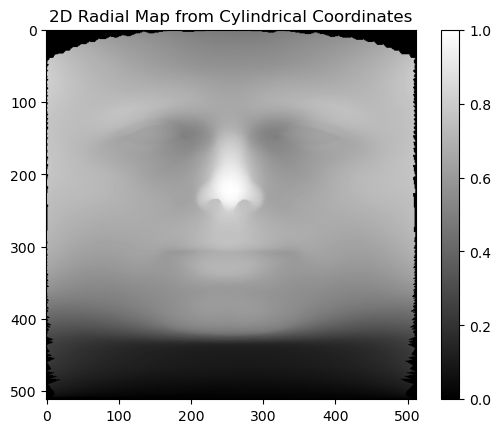

In [41]:
%matplotlib inline
plt.imshow(interpolated_map_normalized, cmap='gray')
plt.colorbar()
plt.title("2D Radial Map from Cylindrical Coordinates")
plt.show()

In [42]:
# Pre-calculate constants
phi_values = (np.arange(res_phi) / (res_phi - 1)) * np.pi - np.pi / 2
y_max = np.max(vertices[:, 1])
y_min = np.min(vertices[:, 1])
y_values = y_max - (np.arange(res_y) / (res_y - 1)) * (y_max - y_min)

# Create mesh grids for phi and y
phi_grid, y_grid = np.meshgrid(phi_values, y_values)

# Flatten and filter out zero-radius points
valid_indices = radial_map_normalized != 0
r_flat = radial_map_normalized[valid_indices]
phi_flat = phi_grid[valid_indices]
y_flat = y_grid[valid_indices]

# Convert back to Cartesian coordinates
x = r_flat * np.sin(phi_flat) + center_x
z = r_flat * np.cos(phi_flat)

# Combine the coordinates
reconstructed_vertices = np.vstack((x, y_flat, z)).T

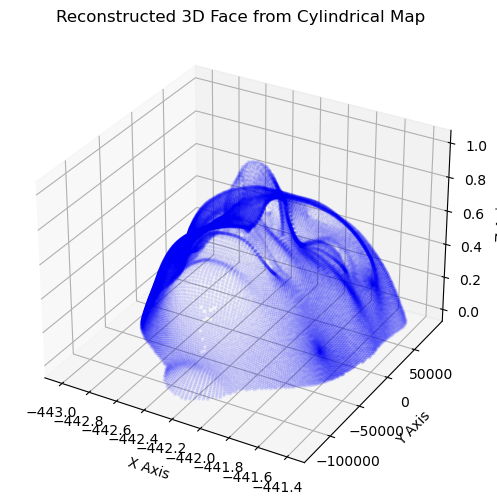

In [43]:
# Plotting the reconstructed vertices
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Assuming reconstructed_vertices contains [x, y, z] coordinates
ax.scatter(reconstructed_vertices[:,0], reconstructed_vertices[:,1], reconstructed_vertices[:,2], color='blue', s=3, alpha=0.08)

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('Reconstructed 3D Face from Cylindrical Map')
# ax.view_init(elev=90, azim=270)
plt.show()


In [44]:
# Pre-calculate constants
phi_factor = np.pi / (res_phi - 1)
y_max = np.max(vertices[:, 1])
y_min = np.min(vertices[:, 1])
y_range = y_max - y_min

# Create mesh grids for phi and y
phi_grid, y_grid = np.meshgrid(np.arange(res_phi) * phi_factor - np.pi / 2, 
                               y_max - np.arange(res_y) / (res_y - 1) * y_range)

# Flatten and filter out zero-radius points
valid_indices = interpolated_map_normalized != 0
r_flat = interpolated_map_normalized[valid_indices]
phi_flat = phi_grid[valid_indices]
y_flat = y_grid[valid_indices]

# Convert back to Cartesian coordinates
x = r_flat * np.sin(phi_flat) + center_x
z = r_flat * np.cos(phi_flat)

# Combine the coordinates
reconstructed_vertices_interpolated = np.vstack((x, y_flat, z)).T

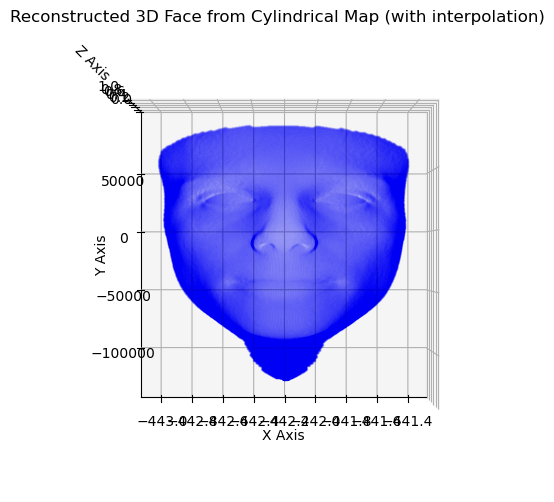

In [48]:
import matplotlib.pyplot as plt

# Plotting the reconstructed vertices
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Assuming reconstructed_vertices contains [x, y, z] coordinates
ax.scatter(reconstructed_vertices_interpolated[:,0], reconstructed_vertices_interpolated[:,1], reconstructed_vertices_interpolated[:,2], color='blue', s=1, alpha=0.03)

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('Reconstructed 3D Face from Cylindrical Map (with interpolation)')
# rotate the following line 30 degrees right
ax.view_init(elev=90, azim=270)  # Updated azimuth angle to rotate 30 degrees right
plt.show()

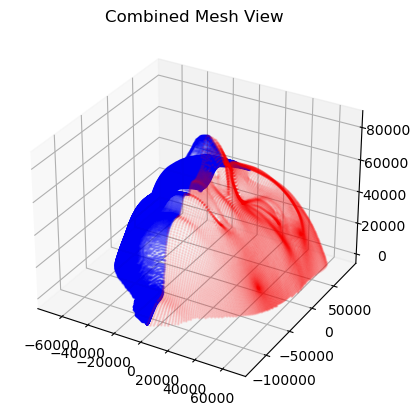

In [26]:
%matplotlib inline

# Assuming scaled_reconstructed and scaled_shifted are already defined
# Split the models in half (modify the condition as per your model's orientation)
half_index_reconstructed = np.median(reconstructed_vertices_interpolated[:, 0])
half_index_shifted = np.median(cropped_vertices[:, 0])

# Use only half of each model
half_reconstructed = reconstructed_vertices_interpolated[reconstructed_vertices_interpolated[:, 0] <= half_index_reconstructed]
half_shifted = cropped_vertices[cropped_vertices[:, 0] > half_index_shifted]

# Combine the halves
combined_vertices = np.vstack((half_reconstructed, half_shifted))

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the combined mesh
ax.scatter(half_reconstructed[:, 0], half_reconstructed[:, 1], half_reconstructed[:, 2], s=1, alpha=0.06, color='blue')
ax.scatter(half_shifted[:, 0], half_shifted[:, 1], half_shifted[:, 2], s=1, alpha=0.1, color='red')

# Set the view angle
# ax.view_init(elev=90, azim=270)

ax.set_title("Combined Mesh View")

plt.show()

In [27]:
def calculate_point_to_surface_distances(mesh_vertices, mesh_faces, point_cloud):
    # Create a trimesh object from the mesh
    mesh = trimesh.Trimesh(vertices=mesh_vertices, faces=mesh_faces, process=False)

    # Use trimesh's nearest.on_surface to find the closest point on the mesh for each point in the point cloud
    closest_points, distances, _ = trimesh.proximity.closest_point(mesh, point_cloud)

    return distances

In [28]:
distances = calculate_point_to_surface_distances(cropped_vertices, cropped_faces, reconstructed_vertices_interpolated)

In [29]:
# Calculate statistics
mean_distance = np.mean(distances)
median_distance = np.median(distances)
std_distance = np.std(distances)
hausdorff_distance = distances.max()

print(f"Mean Distance: {mean_distance}")
print(f"Median Distance: {median_distance}")
print(f"Standard Deviation: {std_distance}")
print(f"Hausdorff Distance: {hausdorff_distance}")

Mean Distance: 87.06860356130325
Median Distance: 68.4188730486786
Standard Deviation: 80.46564514042629
Hausdorff Distance: 1100.3601295209435


In [130]:
from mpl_toolkits.mplot3d import Axes3D

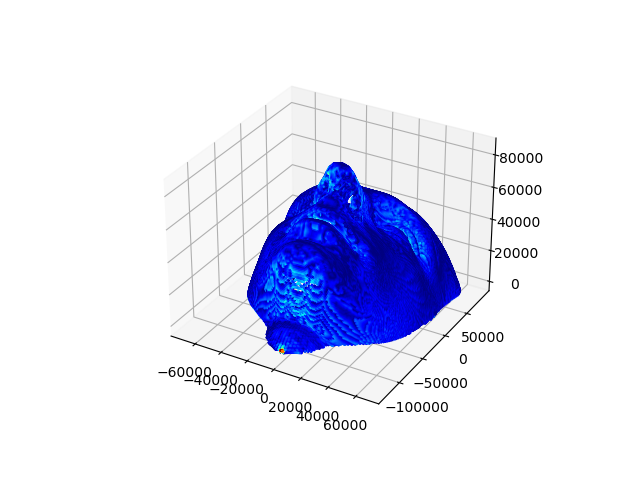

In [30]:
%matplotlib widget

normalized_distances = (distances - np.min(distances)) / (np.max(distances) - np.min(distances))

# Create a scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(reconstructed_vertices_interpolated[:, 0], reconstructed_vertices_interpolated[:, 1], reconstructed_vertices_interpolated[:, 2], c=normalized_distances, cmap='jet', s=0.5)

plt.show()
